In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
import sqlalchemy
import sqlite3
import os
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
os.getcwd()
new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles'
os.chdir(new_path)

# Applying SQL to Movies

In this notebook I show you how I run and use **SQL** through special engines in **Python** to manage large databases & insightfully answer questions with additional analysis through libraries (Plotly, Seaborn, sk-learn). 

#### Why `SQL` with a  `Python` engine?

I will be running my queries using `Python` engines **SQLAlchemy** & **SQLite** in absence of a DMBS. 

I use a combination of the two engines in a **sandboxed workflow** because debugging is easier with `%sql` magic. After I've found the proper query, I like to copy it over to the `pd.read_sql` command for visualization, modeling, and export with Pandas, sklearn, and other Python libraries. This is a worklow I learned at UC Berkeley's Advanced Data Science Principles course, **Data 100**.

### The Data: IMDb Movie Database

To apply SQL, I will be using a subset of [IMDb's Movie Database](https://www.imdb.com). The year range is 1902-2021.



#### SQLite connection

In [3]:
conn = sqlite3.connect('imdbmini.db')

In [4]:
#load
%load_ext sql

In [5]:
%sql sqlite:///imdbmini.db

## SQLAlchemy connection

In [6]:
sqlite_conn = 'sqlite:///imdbmini.db'

In [7]:
engine = sqlalchemy.create_engine(sqlite_conn)
connection = engine.connect()

## Preview of the Total IMDB Database 

In [8]:
%%sql 
SELECT * FROM sqlite_master WHERE type='table';

 * sqlite:///imdbmini.db
Done.


type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


There are 4 tables in this database: `Name`, `Role`, `Rating`, and `Title`.

<details>
    <summary>[<b>Click for Table Schema</b>] See descriptions of each table's data.</summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (text) - alphanumeric unique identifier of the name/person
- primaryName (text)– name by which the person is most often credited
- birthYear (integer) – in YYYY format
- deathYear (integer) – in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given tconst
- nconst (text) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and votes information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- averageRating (real) – weighted average of all the individual user ratings
- numVotes (integer) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the filmmakers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- year (YYYY) – represents the release year of a title.
- runtimeMinutes (integer)  – primary runtime of the title, in minutes
    
</details>

<br/><br/>

From the above descriptions, we can conclude:
* `Name.nconst` and `Title.tconst` are **primary keys** of the `Name` and `Title` tables, respectively.
* that `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

### Previewing the Title table
What kind of information exists regarding movie titles in this database?

In [9]:
%%sql
SELECT * FROM Title
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
417,short,A Trip to the Moon,Le voyage dans la lune,0,1902,None,13,"Action,Adventure,Comedy"
4972,movie,The Birth of a Nation,The Birth of a Nation,0,1915,None,195,"Drama,History,War"
10323,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0,1920,None,76,"Fantasy,Horror,Mystery"
12349,movie,The Kid,The Kid,0,1921,None,68,"Comedy,Drama,Family"
13442,movie,Nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,None,94,"Fantasy,Horror"


### What can we learn from the Titles dataset? 

**What are the **top 10** highest rated movies?**

In [10]:
%%sql
SELECT primaryTitle AS title, 
    CAST(Rating.numVotes AS int) AS numVotes, 
    averageRating
FROM Rating
JOIN Title
ON Rating.tconst = Title.tconst
ORDER BY numVotes DESC
LIMIT 10;

 * sqlite:///imdbmini.db
Done.


title,numVotes,averageRating
The Shawshank Redemption,2462686,9.3
The Dark Knight,2417875,9.0
Inception,2169255,8.8
Fight Club,1939312,8.8
Pulp Fiction,1907561,8.9
Forrest Gump,1903969,8.8
Game of Thrones,1874040,9.2
The Matrix,1756469,8.7
The Lord of the Rings: The Fellowship of the Ring,1730296,8.8
The Lord of the Rings: The Return of the King,1709023,8.9


### What about Harry Potter Movies ? 
#### How many movies, when were they made, how long are they?

FYI: I do NOT consider "Fantastic Beasts" as belonging with Harry Potter...

In [11]:
%%sql
SELECT tconst AS id,
    titleType, 
    primaryTitle AS movieName, 
    startYear AS yearMade, 
    runtimeMinutes FROM Title
WHERE primaryTitle LIKE '%Harry%' AND primaryTitle LIKE '%Potter%';

 * sqlite:///imdbmini.db
Done.


id,titleType,movieName,yearMade,runtimeMinutes
241527,movie,Harry Potter and the Sorcerer's Stone,2001,152
295297,movie,Harry Potter and the Chamber of Secrets,2002,161
304141,movie,Harry Potter and the Prisoner of Azkaban,2004,142
330373,movie,Harry Potter and the Goblet of Fire,2005,157
373889,movie,Harry Potter and the Order of the Phoenix,2007,138
417741,movie,Harry Potter and the Half-Blood Prince,2009,153
926084,movie,Harry Potter and the Deathly Hallows: Part 1,2010,146
1201607,movie,Harry Potter and the Deathly Hallows: Part 2,2011,130


### Im going to deep-dive into my favorite genre:  Sci-Fi Drama 
(my favorite)

### problem:
The genres column applies multiple genres to every movie. This makes it ***really hard*** to find a list of every unique genre type, because every unique instance of the genre list is "distinct". 

In [12]:
%%sql
SELECT DISTINCT genres
FROM Title
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


genres
"Action,Adventure,Comedy"
"Drama,History,War"
"Fantasy,Horror,Mystery"
"Comedy,Drama,Family"
"Fantasy,Horror"


In [13]:
%%sql genre_sql <<
SELECT * FROM Title;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable genre_sql


In [14]:
genre_df = genre_sql.DataFrame()

#pythonically
#genre_list = []
#genre_list = [word for sentence in genre_df["genres"].str.split(",") 
#                  for word in sentence 
#                      if word not in genre_list]
#genre_list

#iteratively
genres = []
type(genre_df["genres"][0])

for i in genre_df["genres"].str.split(","):
    for j in i:
        if j not in genres: 
            genres.append(j)

genres

['Action',
 'Adventure',
 'Comedy',
 'Drama',
 'History',
 'War',
 'Fantasy',
 'Horror',
 'Mystery',
 'Family',
 'Romance',
 'Thriller',
 'Sci-Fi',
 'Biography',
 'Documentary',
 'Music',
 'Short',
 'Crime',
 'Musical',
 'Animation',
 'Film-Noir',
 'Western',
 'Sport',
 'News',
 'Talk-Show',
 'Game-Show',
 'Reality-TV']

Now I have a list of genres names to work with.

#### What are the top-rated Sci-Drama movies of all time (within range)? 

In [15]:
%%sql 
SELECT T.tconst AS id,
  primaryTitle AS title, 
  titleType,
  CAST(runtimeMinutes AS int) AS time,  
  CAST(startYear AS int) AS year,
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings  
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE time > 0 AND -- get rid of outliers and missing values --
      year > 0     -- get rid of missing values --
      AND titleType = "movie"
      AND genres LIKE "%Sci-Fi%" AND genres LIKE "%DRAMA%"
ORDER BY numRatings DESC
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


id,title,titleType,time,year,rating,numRatings
816692,Interstellar,movie,169,2014,8.6,1613897
482571,The Prestige,movie,130,2006,8.5,1244379
434409,V for Vendetta,movie,132,2005,8.1,1065965
338013,Eternal Sunshine of the Spotless Mind,movie,108,2004,8.3,948018
3659388,The Martian,movie,144,2015,8.0,794444


### As of today (2024) the ratings have changed! 
Remember this dataset was collected from 2021, so I've accounted for that in this [IMDB](https://www.imdb.com/search/title/?title_type=feature&genres=sci-fi,drama&release_date=,2022-01-01&sort=num_votes,desc) search. But naturally, 3 years of additional ratings have shifted things.

It looks like "Avengers: Endgame" has gone up to 3rd place, shifting  "V for Vendetta", "Eternal Sunshine of the Spotless Mind" & "The Martian" down.

<center>
<img alt="top5scidrammoves" src="top5scidram.png" width="500px;" />
</center>

#### Im going to convert this into a Python dataframe so that I can explore it a bit more

In [16]:
%%sql sdram_movies_sql <<
SELECT T.tconst AS id,
  primaryTitle AS title, 
  titleType,
  CAST(runtimeMinutes AS int) AS time,  
  CAST(startYear AS int) AS year,
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE time > 0 AND -- get rid of outliers and missing values --
      year > 0     -- get rid of missing values --
      AND titleType = "movie"
      AND genres LIKE "%Sci-Fi%" AND genres LIKE "%DRAMA%"
ORDER BY numRatings DESC;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable sdram_movies_sql


In [17]:
sdram_df = sdram_movies_sql.DataFrame()
sdram_df

,id,title,titleType,time,year,rating,numRatings
0,816692,Interstellar,movie,169,2014,8.6,1613897
1,482571,The Prestige,movie,130,2006,8.5,1244379
2,434409,V for Vendetta,movie,132,2005,8.1,1065965
3,338013,Eternal Sunshine of the Spotless Mind,movie,108,2004,8.3,948018
4,3659388,The Martian,movie,144,2015,8.0,794444
...,...,...,...,...,...,...,...
129,97368,The Fly II,movie,105,1989,5.1,22105
130,1928340,After the Dark,movie,107,2013,5.7,21840
131,51622,The Fly,movie,94,1958,7.1,21837
132,1748207,Sound of My Voice,movie,87,2011,6.6,21531


### Average Ratings for Crime Drama movies have gone down.

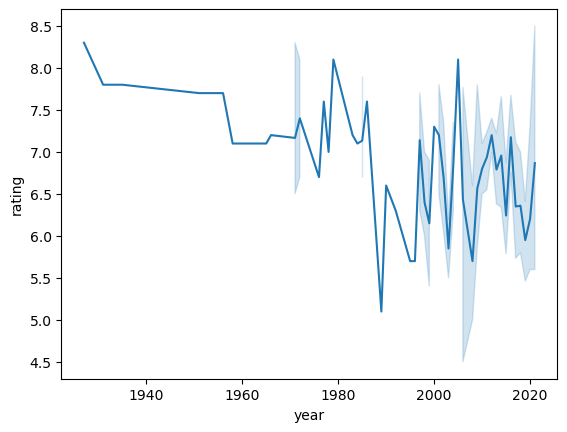

In [18]:
sns.lineplot(data=sdram_df, x="year", y="rating");

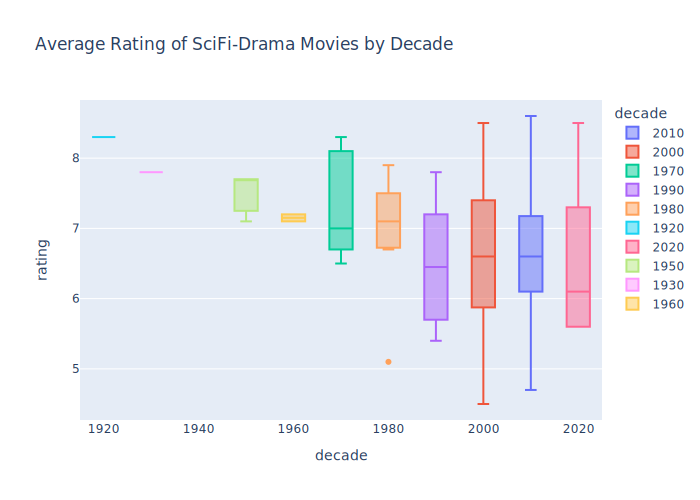

In [19]:
sdram_df['decade'] = (sdram_df['year'] // 10) * 10
fig = px.box(sdram_df, x = 'decade', y = 'rating', color = "decade", title=
      "Average Rating of SciFi-Drama Movies by Decade")

fig.show(renderer="svg")

### What can we find out about the first spike right before the 1980s?


In [25]:
%%sql 
SELECT T.tconst AS id,
    titleType AS movie,
    primaryTitle AS title,
    startYear AS year,
    runtimeMinutes,
    genres,
    averageRating,
    numVotes
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE titleType = "movie"
      AND startYear < 1990 AND startYear > 1979
      AND genres LIKE "%Sci-Fi%"     
ORDER BY averageRating DESC
;

 * sqlite:///imdbmini.db
Done.


id,movie,title,year,runtimeMinutes,genres,averageRating,numVotes
88763,movie,Back to the Future,1985,116,"Adventure,Comedy,Sci-Fi",8.5,1112320
94517,tvSeries,Mystery Science Theater 3000,1988,92,"Comedy,Sci-Fi",8.5,23749
94535,tvSeries,Red Dwarf,1988,30,"Comedy,Sci-Fi",8.4,33671
90605,movie,Aliens,1986,137,"Action,Adventure,Sci-Fi",8.3,678152
83658,movie,Blade Runner,1982,117,"Action,Sci-Fi,Thriller",8.1,721364
84787,movie,The Thing,1982,109,"Horror,Mystery,Sci-Fi",8.1,390752
88247,movie,The Terminator,1984,107,"Action,Sci-Fi",8.0,820648
88846,movie,Brazil,1985,132,"Drama,Sci-Fi",7.9,194638
83866,movie,E.T. the Extra-Terrestrial,1982,115,"Family,Sci-Fi",7.8,387066
93773,movie,Predator,1987,107,"Action,Adventure,Sci-Fi",7.8,386947


### What's about the dramatic drop late 80s to 90s?

tbd..

### Post 90s seem to be volitale.

tbd...

Ratings of this genre are really variable through time! 

### How does this compare to the Romance  movie genre ? 

In [303]:
%%sql 
SELECT T.tconst AS id,
  primaryTitle AS title, 
  titleType,
  CAST(runtimeMinutes AS int) AS time,  
  CAST(startYear AS int) AS year,
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings  
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE time > 0 AND -- get rid of outliers and missing values --
      year > 0     -- get rid of missing values --
      AND titleType = "movie"
      AND genres LIKE "%Romance%"
ORDER BY numRatings DESC
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


id,title,titleType,time,year,rating,numRatings
109830,Forrest Gump,movie,142,1994,8.8,1903969
120338,Titanic,movie,194,1997,7.8,1091853
338013,Eternal Sunshine of the Spotless Mind,movie,108,2004,8.3,948018
119217,Good Will Hunting,movie,126,1997,8.3,900171
1010048,Slumdog Millionaire,movie,120,2008,8.0,817735


In [304]:
%%sql  rom_movies_sql <<
SELECT T.tconst AS id,
  primaryTitle AS title, 
  titleType,
  CAST(runtimeMinutes AS int) AS time,  
  CAST(startYear AS int) AS year,
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings  
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE time > 0 AND -- get rid of outliers and missing values --
      year > 0     -- get rid of missing values --
      AND titleType = "movie"
      AND genres LIKE "%Romance%"
ORDER BY numRatings DESC;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable rom_movies_sql


In [305]:
rom_df = rom_movies_sql.DataFrame()
rom_df

,id,title,titleType,time,year,rating,numRatings
0,109830,Forrest Gump,movie,142,1994,8.8,1903969
1,120338,Titanic,movie,194,1997,7.8,1091853
2,338013,Eternal Sunshine of the Spotless Mind,movie,108,2004,8.3,948018
3,119217,Good Will Hunting,movie,126,1997,8.3,900171
4,1010048,Slumdog Millionaire,movie,120,2008,8.0,817735
...,...,...,...,...,...,...,...
1000,31725,Ninotchka,movie,110,1939,7.9,20081
1001,118760,The Boxer,movie,113,1997,7.0,20071
1002,409184,Russian Dolls,movie,125,2005,7.0,20070
1003,2302966,I,movie,188,2015,7.4,20052


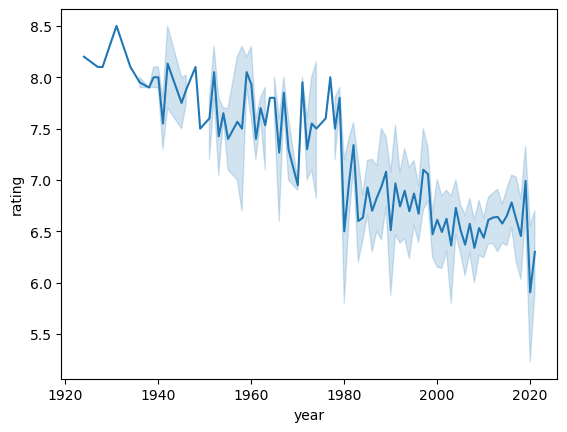

In [306]:
sns.lineplot(data=rom_df, x="year", y="rating");

Wow a sharp decline. Is romance dead?

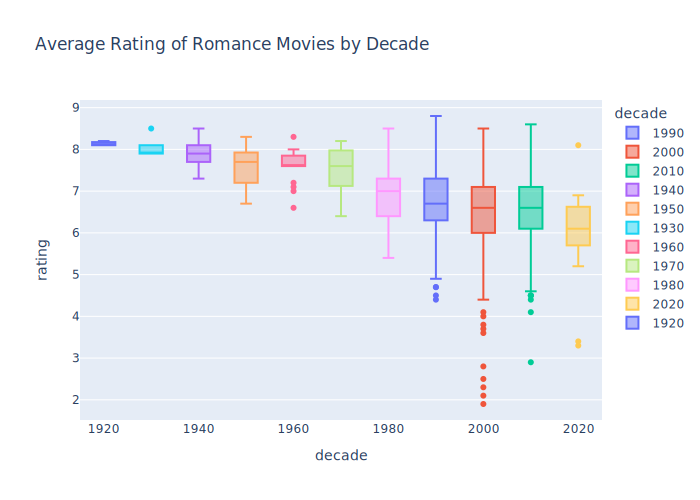

In [321]:
rom_df['decade'] = (rom_df['year'] // 10) * 10
fig = px.box(rom_df, x = 'decade', y = 'rating', color = "decade", title=
      "Average Rating of Romance Movies by Decade")

fig.show(renderer="svg")

### Diving deeper into my favorite Sci-Fi Drama: Gattaca

In [308]:
%%sql
SELECT titleType,
    primaryTitle AS title, 
    startYear AS year,
    runtimeMinutes,
    averageRating, 
    numVotes,
    genres
FROM Rating
JOIN Title
ON Rating.tconst = Title.tconst
WHERE primaryTitle LIKE "Gattaca";

 * sqlite:///imdbmini.db
Done.


titleType,title,year,runtimeMinutes,averageRating,numVotes,genres
movie,Gattaca,1997,106,7.8,289846,"Drama,Sci-Fi,Thriller"


In [309]:
%%sql

SELECT titleType, 
    primaryTitle AS title, 
    startYear AS year, 
    genres,
    category, 
    characters,
    primaryName
FROM Title
JOIN Role ON Role.tconst = Title.tconst
JOIN Name ON Name.nconst = role.nconst
WHERE primaryTitle LIKE "%Gattaca%" AND category LIKE "%actor%";

 * sqlite:///imdbmini.db
Done.


titleType,title,year,genres,category,characters,primaryName
movie,Gattaca,1997,"Drama,Sci-Fi,Thriller",actor,"[""Vincent"",""Jerome""]",Ethan Hawke
movie,Gattaca,1997,"Drama,Sci-Fi,Thriller",actor,"[""Jerome"",""Eugene""]",Jude Law
movie,Gattaca,1997,"Drama,Sci-Fi,Thriller",actor,"[""Director Josef""]",Gore Vidal


### How great are Uma Thurman's movies?

In [322]:
%%sql  uma_sql <<
SELECT primaryName AS name,
    characters,
    startYear AS year,
    primaryTitle AS title,
    averageRating,
    numVotes,
    genres
FROM Name
JOIN Role ON Name.nconst = Role.nconst
JOIN Title ON Title.tconst = Role.tconst
JOIN Rating ON Rating.tconst = Title.tconst
WHERE primaryName LIKE "%Uma Thurman%"
ORDER BY averageRating DESC;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable uma_sql


In [323]:
uma_df = uma_sql.DataFrame()
uma_df.head()

,name,characters,year,title,averageRating,numVotes,genres
0,Uma Thurman,"[""Mia Wallace""]",1994,Pulp Fiction,8.9,1907561,"Crime,Drama"
1,Uma Thurman,"[""The Bride""]",2003,Kill Bill: Vol. 1,8.1,1045398,"Action,Crime,Drama"
2,Uma Thurman,"[""Beatrix Kiddo aka The Bride aka Black Mamba ...",2004,Kill Bill: Vol. 2,8.0,713256,"Action,Crime,Thriller"
3,Uma Thurman,"[""Irene""]",1997,Gattaca,7.8,289846,"Drama,Sci-Fi,Thriller"
4,Uma Thurman,"[""Fantine""]",1998,Les Misérables,7.4,40240,"Crime,Drama,History"


 ## WIP: PCA & Clustering

### What movies get the highest ratings - as predicted my genre?

In [326]:
%%sql pca_pre_sql <<
SELECT *
FROM Title 
JOIN Rating ON Title.tconst = Rating.tconst;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable pca_pre_sql


In [328]:
pca_df = pca_pre_sql.DataFrame()
pca_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,tconst,averageRating,numVotes
0,417,short,A Trip to the Moon,Le voyage dans la lune,0,1902,None,13,"Action,Adventure,Comedy",417,8.2,46382
1,4972,movie,The Birth of a Nation,The Birth of a Nation,0,1915,None,195,"Drama,History,War",4972,6.3,23836
2,10323,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0,1920,None,76,"Fantasy,Horror,Mystery",10323,8.1,60244
3,12349,movie,The Kid,The Kid,0,1921,None,68,"Comedy,Drama,Family",12349,8.3,120059
4,13442,movie,Nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,None,94,"Fantasy,Horror",13442,7.9,92218
